# Goal

* Trying varying levels of bandwidth and DBL scaling with pre-fractionation abundances ('DBL-comm')
* Trying to refine the parameter fit a bit more

## Init

In [1]:
import os
import glob
import re
import nestly

In [2]:
%load_ext rpy2.ipython
%load_ext pushnote

In [3]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


### BD min/max

In [4]:
%%R
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

cat('Min BD:', min_BD, '\n')
cat('Max BD:', max_BD, '\n')

Min BD: 1.67323 
Max BD: 1.7744 


# Nestly

* assuming fragments already simulated

In [10]:
workDir = '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/'
buildDir = os.path.join(workDir, 'rep3_DBL-comm_bw2')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde_parsed.pkl'
commFile = '/home/nick/notebook/SIPSim/dev/fullCyc/fullCyc_12C-Con_trm_comm.txt'

nreps = 10

In [11]:
# building tree structure
nest = nestly.Nest()

# varying params
nest.add('DBL_scaling', [0.1, 0.2, 0.3])
nest.add('rep', [x + 1 for x in xrange(nreps)])


## set params
nest.add('bandwidth', [0.08], create_dir=False)
nest.add('abs', ['1e9'], create_dir=False)
nest.add('percIncorp', [0], create_dir=False)
nest.add('percTaxa', [0], create_dir=False)
nest.add('np', [10], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('commFile', [commFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [12]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'

echo '# shuffling taxa in comm file'
comm_shuffle_taxa.r {commFile} > comm.txt

    
echo '# adding diffusion'    
SIPSim diffusion \
    {fragFile} \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --comm comm.txt \
    --commx {DBL_scaling} \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm comm.txt \
    --bw {bandwidth} \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    comm.txt \
    > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
#-- w/ PCR simulation --#
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    

#-- w/out PCR simulation --#    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_sub.txt \
    > OTU_abs{abs}_sub_meta.txt    

Writing /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/SIPSimRun.sh


In [13]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d rep3_DBL-comm_bw2 --log-file log.txt -j 2

2016-02-24 07:51:12,379 * INFO * Template: ./SIPSimRun.sh
2016-02-24 07:51:12,380 * INFO * [90455] Started ./SIPSimRun.sh in rep3_DBL-comm_bw2/0.1/7
2016-02-24 07:51:12,382 * INFO * [90456] Started ./SIPSimRun.sh in rep3_DBL-comm_bw2/0.1/9
2016-02-24 08:04:51,094 * INFO * [90455] rep3_DBL-comm_bw2/0.1/7 Finished with 0
2016-02-24 08:04:51,114 * INFO * [91519] Started ./SIPSimRun.sh in rep3_DBL-comm_bw2/0.1/8
2016-02-24 08:04:51,353 * INFO * [90456] rep3_DBL-comm_bw2/0.1/9 Finished with 0
2016-02-24 08:04:51,373 * INFO * [91526] Started ./SIPSimRun.sh in rep3_DBL-comm_bw2/0.1/3
2016-02-24 08:19:12,649 * INFO * [91519] rep3_DBL-comm_bw2/0.1/8 Finished with 0
2016-02-24 08:19:12,695 * INFO * [92033] Started ./SIPSimRun.sh in rep3_DBL-comm_bw2/0.1/10
2016-02-24 08:19:17,330 * INFO * [91526] rep3_DBL-comm_bw2/0.1/3 Finished with 0
2016-02-24 08:19:17,366 * INFO * [92144] Started ./SIPSimRun.sh in rep3_DBL-comm_bw2/0.1/2
2016-02-24 08:33:39,351 * INFO * [92033] rep3_DBL-comm_bw2/0.1/10 Finis

# Loading non-PCR subsampled OTU tables

In [131]:
OTU_files = !find $buildDir -name "OTU_abs1e9_sub.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/9/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/8/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/3/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/10/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/2/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/1/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/4/OTU_abs1e9_sub.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/5/OTU_abs1e9_sub.txt',


In [132]:
%%R -i OTU_files
# loading files

df.SIM = list()
for (x in OTU_files){
    df = read.delim(x, sep='\t')
    xx = strsplit(x, '/')[[1]]
    df$DBL_scale = xx[10] %>% as.numeric
    #df$bw = xx[11] %>% as.numeric
    df$SIM_rep = xx[11] %>% as.numeric
    df.SIM[[x]] = df
    }
df.SIM = do.call('rbind', df.SIM)
df.SIM$file = gsub('\\.[0-9]+$', '', rownames(df.SIM))
rownames(df.SIM) = 1:nrow(df.SIM)
df.SIM %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1  -inf-1.660 Acaryochloris_marina_MBIC11017   -Inf  1.659  1.659     3
2       1 1.660-1.662 Acaryochloris_marina_MBIC11017  1.660  1.661  1.662     2
3       1 1.662-1.664 Acaryochloris_marina_MBIC11017  1.662  1.663  1.664     2
     rel_abund DBL_scale SIM_rep
1 0.0002294806       0.1       7
2 0.0001674621       0.1       7
3 0.0001960400       0.1       7
                                                                                                        file
1 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9_sub.txt
2 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9_sub.txt
3 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9_sub.txt


# BD range where an OTU is detected 

* Do the simulated OTU BD distributions span the same BD range of the emperical data?

In [133]:
comm_files = !find $buildDir -name "comm.txt"
comm_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/9/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/8/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/3/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/10/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/2/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/1/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/4/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/5/comm.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/6/

In [134]:
%%R -i comm_files

df.SIM.comm = list()
for (x in comm_files){
    df = read.delim(x, sep='\t')
    xx = strsplit(x, '/')[[1]]
    df$DBL_scale = xx[10] %>% as.numeric
    #df$bw = xx[11] %>% as.numeric
    df$SIM_rep = xx[11] %>% as.numeric
    df.SIM.comm[[x]] = df
    }

df.SIM.comm = do.call(rbind, df.SIM.comm)
rownames(df.SIM.comm) = 1:nrow(df.SIM.comm)
df.SIM.comm = df.SIM.comm %>%
    rename('bulk_abund' = rel_abund_perc) %>%
    mutate(bulk_abund = bulk_abund / 100)
df.SIM.comm %>% head(n=3)

  library                        taxon_name bulk_abund rank DBL_scale SIM_rep
1       1 Campylobacter_peloridis_LMG_23910 0.05728702    1       0.1       7
2       1    Taylorella_asinigenitalis_MCE3 0.04295700    2       0.1       7
3       1 Anaplasma_marginale_str_St_Maries 0.02965853    3       0.1       7


In [135]:
%%R
## joining SIP & comm (pre-fractionation)
df.SIM.j = inner_join(df.SIM, df.SIM.comm, c('library' = 'library', 
                                             'taxon' = 'taxon_name',
                                             'DBL_scale' = 'DBL_scale',
                                             'SIM_rep' = 'SIM_rep')) %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD)
    
df.SIM.j %>% head(n=3)

  library    fraction                          taxon BD_min BD_mid BD_max count
1       1 1.675-1.680 Acaryochloris_marina_MBIC11017  1.675  1.677  1.680     5
2       1 1.680-1.684 Acaryochloris_marina_MBIC11017  1.680  1.682  1.684     0
3       1 1.684-1.686 Acaryochloris_marina_MBIC11017  1.684  1.685  1.686     0
     rel_abund DBL_scale SIM_rep
1 0.0002672368       0.1       7
2 0.0000000000       0.1       7
3 0.0000000000       0.1       7
                                                                                                        file
1 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9_sub.txt
2 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9_sub.txt
3 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9_sub.txt
  bulk_abund rank
1 0.00026212  769
2 0.00026212  769
3 0.00026212  769


In [136]:
%%R
# calculating BD range
df.SIM.j.f = df.SIM.j %>%
    filter(count > 0) %>%
    group_by(DBL_scale, SIM_rep) %>%
    mutate(max_BD_range = max(BD_mid) - min(BD_mid)) %>%
    ungroup() %>%
    group_by(DBL_scale, SIM_rep, taxon) %>%
    summarize(mean_bulk_abund = mean(bulk_abund),
              min_BD = min(BD_mid),
              max_BD = max(BD_mid),
              BD_range = max_BD - min_BD,
              BD_range_perc = BD_range / first(max_BD_range) * 100) %>%
    ungroup() %>%
    mutate(SIM_rep = SIM_rep %>% as.character)
    
df.SIM.j.f %>% head(n=3) %>% as.data.frame

  DBL_scale SIM_rep                                taxon mean_bulk_abund min_BD
1       0.1       1       Acaryochloris_marina_MBIC11017    0.0003859507  1.675
2       0.1       1       Acetobacterium_woodii_DSM_1030    0.0009315750  1.675
3       0.1       1 Acetobacter_pasteurianus_IFO_3283-03    0.0002238808  1.675
  max_BD BD_range BD_range_perc
1  1.769    0.094     100.00000
2  1.769    0.094     100.00000
3  1.765    0.090      95.74468


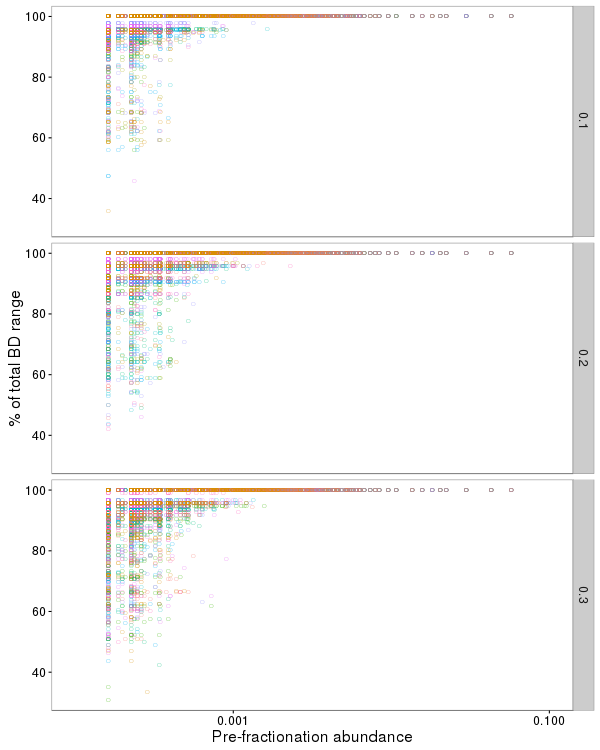

In [137]:
%%R -h 750 -w 600

## plotting
ggplot(df.SIM.j.f, aes(mean_bulk_abund, BD_range_perc, color=SIM_rep)) +
    geom_point(alpha=0.5, shape='O') +
    scale_x_log10(limits=c(0.0001, 0.1)) +
    scale_y_continuous() +
    facet_grid(DBL_scale ~ .) +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )

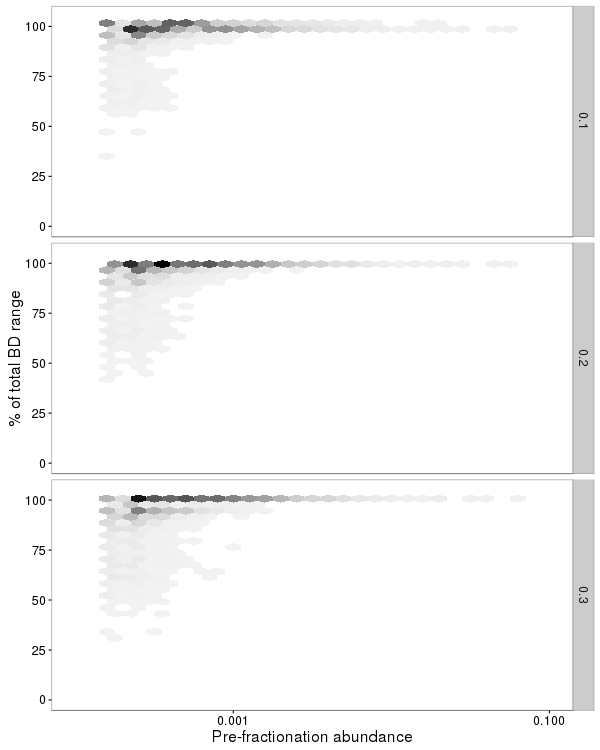

In [146]:
%%R -h 750 -w 600

## plotting
ggplot(df.SIM.j.f, aes(mean_bulk_abund, BD_range_perc)) +
    geom_hex() +
    scale_x_log10(limits=c(0.0001, 0.1)) +
    scale_y_continuous(limits=c(0,105)) +
    scale_fill_gradient(low='grey95', high='black') +
    facet_grid(DBL_scale ~ .) +
    labs(x='Pre-fractionation abundance', y='% of total BD range') +
    #geom_vline(xintercept=0.001, linetype='dashed', alpha=0.5) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        panel.grid = element_blank(),
        legend.position = 'none'
        )

# Assessing diversity

### Asigning zeros

In [28]:
%%R
# giving value to missing abundances
min.pos.val = df.SIM.j %>%
    filter(rel_abund > 0) %>%
    group_by() %>%
    mutate(min_abund = min(rel_abund)) %>%
    ungroup() %>%
    filter(rel_abund == min_abund)

min.pos.val = min.pos.val[1,'rel_abund'] %>% as.numeric
imp.val = min.pos.val / 10


# convert numbers
df.SIM.j[df.SIM.j$rel_abund == 0, 'abundance'] = imp.val

# another closure operation
df.SIM.j = df.SIM.j %>%
    group_by(DBL_scale, SIM_rep, fraction) %>%
    mutate(rel_abund = rel_abund / sum(rel_abund))


# status
cat('Below detection level abundances converted to: ', imp.val, '\n')

Below detection level abundances converted to:  3.334222e-06 


## Plotting Shannon diversity for each

In [29]:
%%R
shannon_index_long = function(df, abundance_col, ...){
    # calculating shannon diversity index from a 'long' formated table
    ## community_col = name of column defining communities
    ## abundance_col = name of column defining taxon abundances
    df = df %>% as.data.frame
    cmd = paste0(abundance_col, '/sum(', abundance_col, ')')
    df.s = df %>%
        group_by_(...) %>%
        mutate_(REL_abundance = cmd) %>%
        mutate(pi__ln_pi = REL_abundance * log(REL_abundance),
               shannon = -sum(pi__ln_pi, na.rm=TRUE)) %>%
        ungroup() %>% 
        dplyr::select(-REL_abundance, -pi__ln_pi) %>%
        distinct_(...) 
    return(df.s)
}

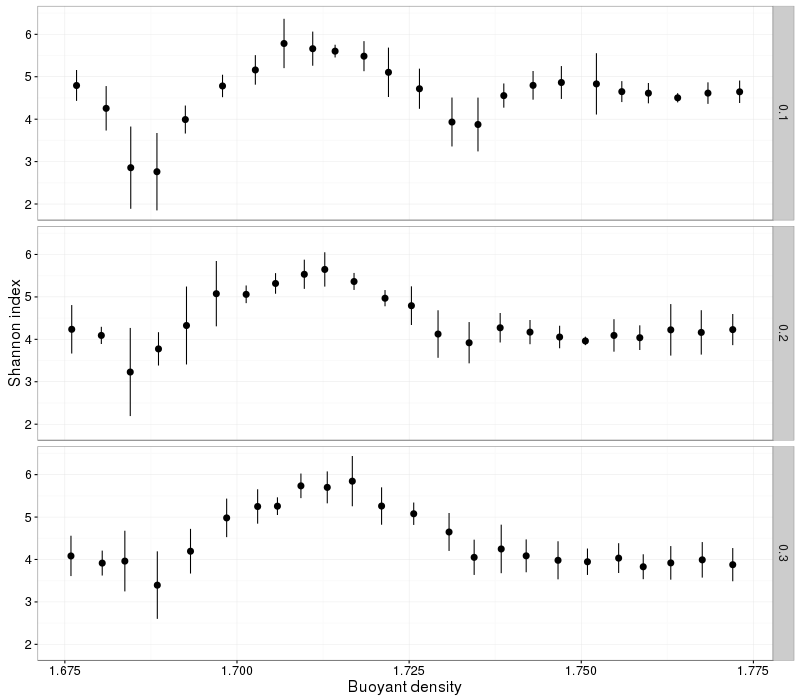

In [30]:
%%R -w 800 -h 700
# calculating shannon
df.SIM.shan = shannon_index_long(df.SIM.j, 'count', 'library', 'fraction', 'DBL_scale') %>%
    filter(BD_mid >= min_BD, 
           BD_mid <= max_BD) 

df.SIM.shan.s = df.SIM.shan %>%
    group_by(DBL_scale, BD_bin = ntile(BD_mid, 24)) %>%
    summarize(mean_BD = mean(BD_mid),
              mean_shannon = mean(shannon),
              sd_shannon = sd(shannon))

# plotting
p = ggplot(df.SIM.shan.s, aes(mean_BD, mean_shannon, 
                             ymin=mean_shannon-sd_shannon,
                             ymax=mean_shannon+sd_shannon)) +
    geom_pointrange() +
    labs(x='Buoyant density', y='Shannon index') +
    facet_grid(DBL_scale ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

# Plotting variance

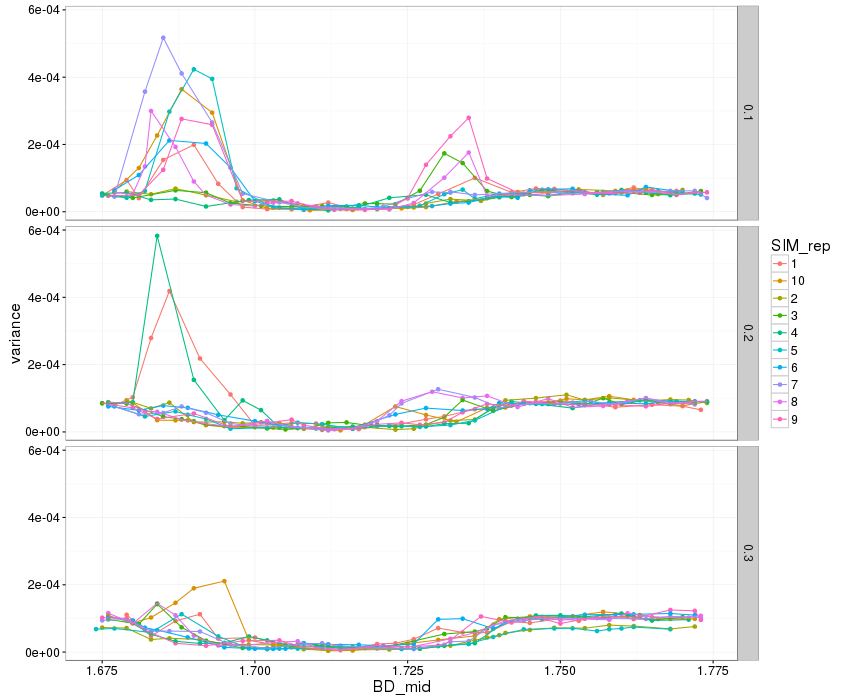

In [36]:
%%R -w 850 -h 700
df.SIM.j.var = df.SIM.j %>%
    group_by(DBL_scale, SIM_rep, fraction) %>%
    mutate(variance = var(rel_abund)) %>%
    ungroup() %>%
    distinct(DBL_scale, SIM_rep, fraction) %>%
    select(DBL_scale, SIM_rep, fraction, variance, BD_mid) %>%
    mutate(SIM_rep = SIM_rep %>% as.character)

ggplot(df.SIM.j.var, aes(BD_mid, variance, color=SIM_rep)) +
    geom_point() +
    geom_line() +
    facet_grid(DBL_scale ~ .) +    
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

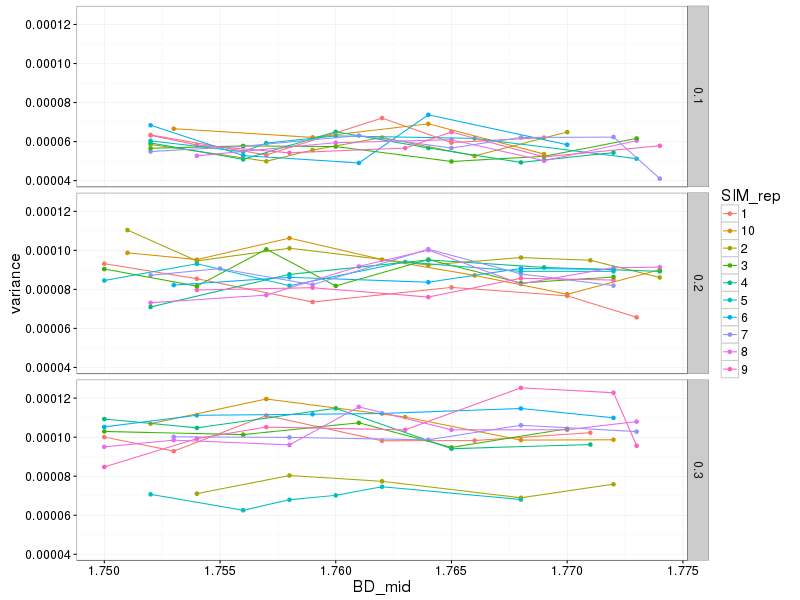

In [38]:
%%R -w 800 -h 600

ggplot(df.SIM.j.var %>% filter(BD_mid >= 1.75), aes(BD_mid, variance, color=SIM_rep)) +
    geom_point() +
    geom_line() +
    facet_grid(DBL_scale ~ .) +    
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

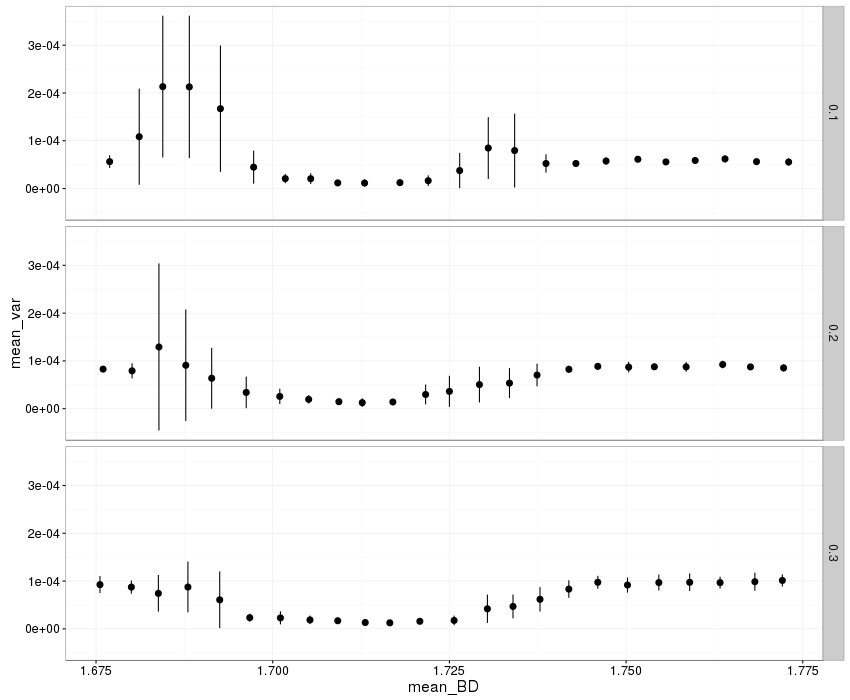

In [42]:
%%R -w 850 -h 700
df.SIM.j.var.s = df.SIM.j.var %>%
    group_by(DBL_scale, BD_bin = ntile(BD_mid, 24)) %>%
    summarize(mean_BD = mean(BD_mid),
              mean_var = mean(variance),
              sd_var = sd(variance)) %>%
    ungroup()

ggplot(df.SIM.j.var.s, aes(mean_BD, mean_var, 
                           ymin=mean_var-sd_var,
                           ymax=mean_var+sd_var)) +
    geom_pointrange() +
    facet_grid(DBL_scale ~ .) +    
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

#### Notes

* increased DBL_scaling is increasing the variance at the heavy tail

# Correlograms

In [97]:
%%R

BD.diffs = function(df){
    BDs = df$BD_mid %>% unique
    df.BD = expand.grid(BDs, BDs)
    df.BD$diff = df.BD %>% apply(1, diff) %>% abs %>% as.vector    
    df.BD = df.BD %>% spread(Var1, diff) 
    rownames(df.BD) = df.BD$Var2
    df.BD$Var2 = NULL
    dist.BD = df.BD %>% as.matrix
    dist.BD[upper.tri(dist.BD, diag=TRUE)] = 0
    dist.BD %>% as.dist
    }

vegdist.by = function(df, ...){
    df.w = df %>%
        select(taxon, rel_abund, fraction, BD_mid) %>%
        spread(taxon, rel_abund) %>%
        as.data.frame()
    
    rownames(df.w) = df.w$BD_mid %>% as.vector
    df.w$BD_mid = NULL
    df.w$fraction = NULL
    
    vegan::vegdist(df.w, ...)
}


dist.match = function(X,D){
    # making sure matrices match
    X.m = X %>% as.matrix
    D.m = D %>% as.matrix
    d = setdiff(rownames(X.m), rownames(D.m))
    if(length(d) > 0){
        print(rownames(X.m))
        print(rownames(D.m))
        print(d)
        stop('Distance matrices don\'t match')
    }
    D.m = D.m[rownames(X.m), colnames(X.m)] 
    D = D.m %>% as.dist
    return(D)
    }

m.corr = function(X, D, ...){
    res = list()
    for (i in 1:length(X)){
        X.d = X[[i]]
        X.d[is.na(X.d)] = 0
        D.d = D[[i]]
        D.d = dist.match(X.d, D.d)
        tmp = vegan::mantel.correlog(X.d, D.d, ...)
        tmp = tmp['mantel.res'][['mantel.res']] %>% as.data.frame
        colnames(tmp) = c('class.index', 'n.dist', 'Mantel.corr', 'Pr', 'Pr.corr')
        res[[i]] = tmp
    }
    return(res)
}

# running
df.SIM.j.d = df.SIM.j %>%
    ungroup() %>%
    filter(BD_mid >= min_BD, BD_mid <= max_BD) %>%
    distinct(DBL_scale, SIM_rep, BD_mid) %>%
    group_by(DBL_scale, SIM_rep) %>%
    nest() %>%
    mutate(dist.bray = lapply(data, vegdist.by),
           dist.BD = lapply(data, BD.diffs),
           mantel.corr = m.corr(dist.bray, dist.BD, n.class=24)) %>%
    select(DBL_scale, SIM_rep, mantel.corr) %>%
    unnest(mantel.corr %>% purrr::map(function(x) x)) 
df.SIM.j.d %>% head

Source: local data frame [6 x 7]

  DBL_scale SIM_rep class.index n.dist Mantel.corr    Pr Pr.corr
      (dbl)   (dbl)       (dbl)  (dbl)       (dbl) (dbl)   (dbl)
1       0.1       7 0.003916667     36  0.18894121 0.007   0.007
2       0.1       7 0.007750000     34  0.14337414 0.013   0.014
3       0.1       7 0.011583333     40  0.07125425 0.148   0.148
4       0.1       7 0.015416667     36 -0.01466834 0.430   0.430
5       0.1       7 0.019250000     32 -0.13129170 0.015   0.052
6       0.1       7 0.023083333     28 -0.09824155 0.070   0.210


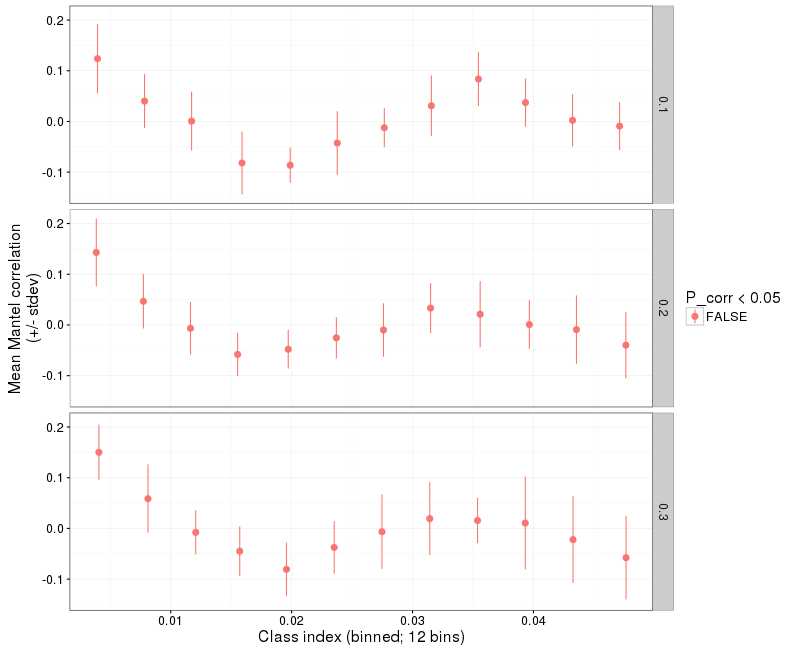

In [99]:
%%R -w 800 -h 650
df.SIM.j.d.s = df.SIM.j.d %>%
    filter(! is.na(Mantel.corr)) %>%
    group_by(DBL_scale, bin = ntile(class.index, 12)) %>%
    summarize(mean.class.index = mean(class.index),
              mean.Mantel.corr = mean(Mantel.corr, na.rm=TRUE),
              sd.Mantel.corr = sd(Mantel.corr, na.rm=TRUE),
              max.Pr.corr = max(Pr.corr, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(significant = ifelse(max.Pr.corr <= 0.05, TRUE, FALSE))


ggplot(df.SIM.j.d.s, aes(mean.class.index, mean.Mantel.corr, color=significant,
                      ymin=mean.Mantel.corr-sd.Mantel.corr,
                      ymax=mean.Mantel.corr+sd.Mantel.corr)) +
    geom_pointrange() +
    scale_color_discrete('P_corr < 0.05') +
    labs(x='Class index (binned; 12 bins)', y='Mean Mantel correlation\n(+/- stdev)') +
    facet_grid(DBL_scale ~ .) +
    theme_bw() +
    theme( 
        text = element_text(size=16)
    ) 

# Plotting absolute abundance distributions 

In [100]:
OTU_files = !find $buildDir -name "OTU_abs1e9.txt"
OTU_files

['/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/9/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/8/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/3/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/10/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/2/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/1/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/4/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/5/OTU_abs1e9.txt',
 '/home/nick/notebook/SIPSim/dev/ful

In [101]:
%%R -i OTU_files
# loading files

df.abs = list()
for (x in OTU_files){
    df = read.delim(x, sep='\t')
    xx = strsplit(x, '/')[[1]]
    df$DBL_scale = xx[10] %>% as.numeric
#    df$bw = xx[11] %>% as.numeric
    df$SIM_rep = xx[11] %>% as.numeric
    df.abs[[x]] = df
    }
df.abs = do.call('rbind', df.abs)
df.abs$file = gsub('\\.[0-9]+$', '', rownames(df.abs))
rownames(df.abs) = 1:nrow(df.abs)
df.abs %>% head(n=3)

  library                          taxon    fraction BD_min BD_mid BD_max count
1       1 Acaryochloris_marina_MBIC11017  -inf-1.660   -Inf  1.659  1.659    28
2       1 Acaryochloris_marina_MBIC11017 1.660-1.662  1.660  1.661  1.662     4
3       1 Acaryochloris_marina_MBIC11017 1.662-1.664  1.662  1.663  1.664     7
     rel_abund DBL_scale SIM_rep
1 0.0001643704       0.1       7
2 0.0001617469       0.1       7
3 0.0002596824       0.1       7
                                                                                                    file
1 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9.txt
2 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9.txt
3 /home/nick/notebook/SIPSim/dev/fullCyc/n1147_frag_norm_9_2.5_n5/rep3_DBL-comm_bw2/0.1/7/OTU_abs1e9.txt


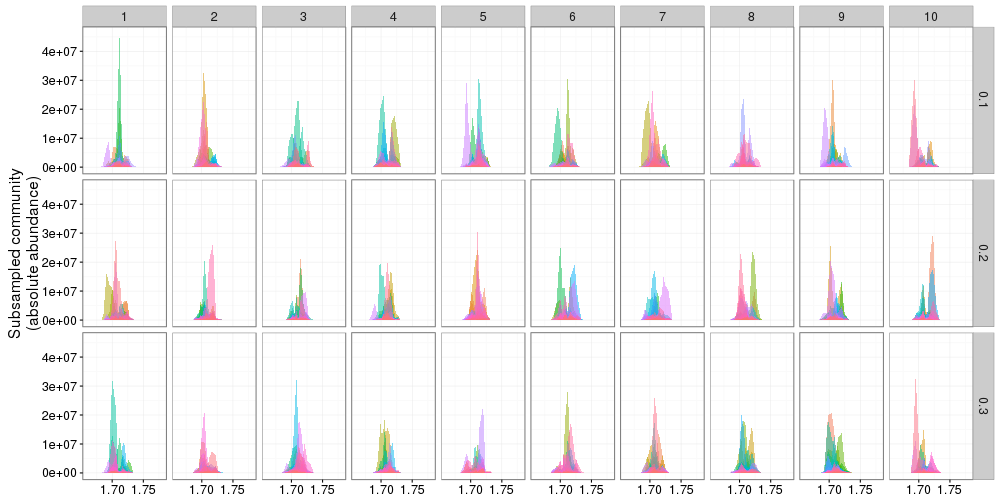

In [104]:
%%R -w 1000 -h 500

ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_area(stat='identity', position='dodge', alpha=0.5) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(DBL_scale ~ SIM_rep) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

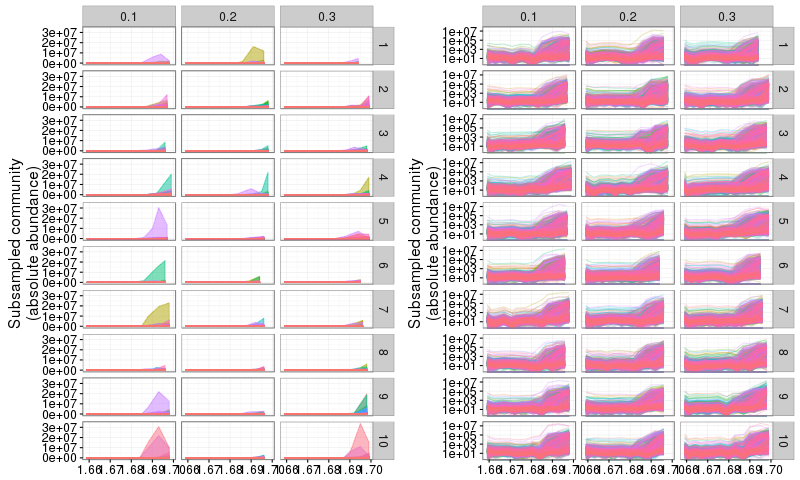

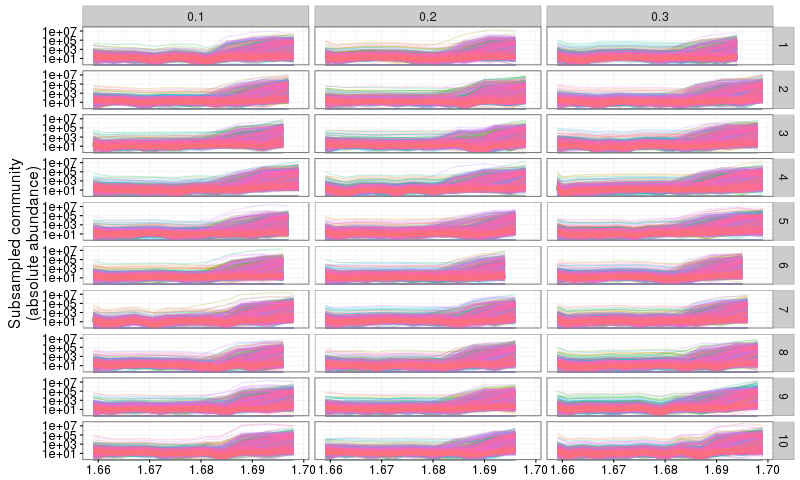

In [105]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid < 1.7), 
            aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ DBL_scale) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )

p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)
p2

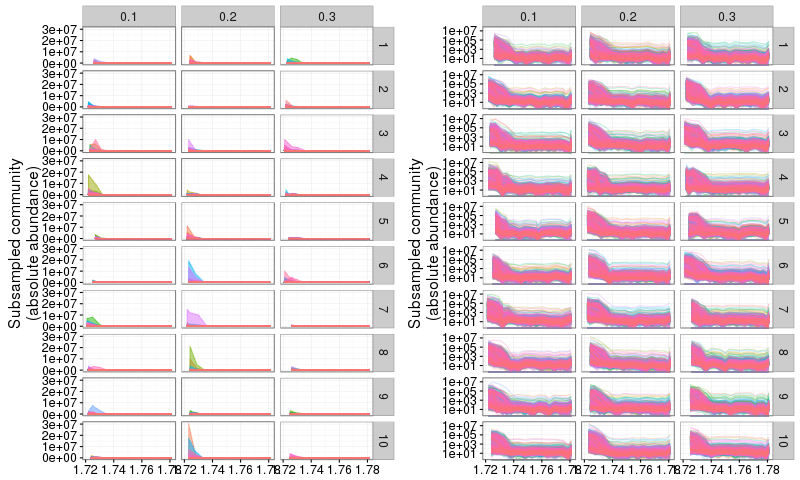

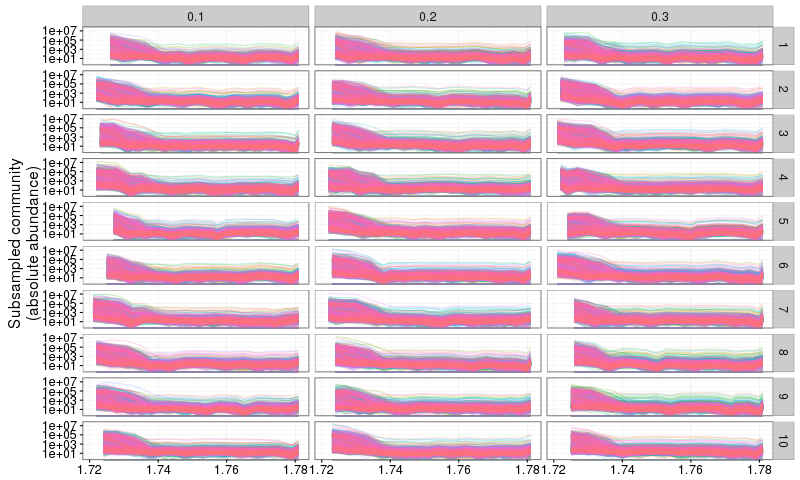

In [106]:
%%R -w 800 

p1 = ggplot(df.abs %>% filter(BD_mid > 1.72), aes(BD_mid, count, fill=taxon, color=taxon)) +
    labs(x='Buoyant density', y='Subsampled community\n(absolute abundance)') +
    facet_grid(SIM_rep ~ DBL_scale) +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'none',
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank()
        )


p2 = p1 + geom_line(alpha=0.25) + scale_y_log10()
p1 = p1 + geom_area(stat='identity', position='dodge', alpha=0.5) 

grid.arrange(p1, p2, ncol=2)
p2